In [1]:
try:
    import visualkeras
except:
    !pip install visualkeras
    import visualkeras

import os
import keras_cv
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import graphviz

/Users/siddheshsongirkar/Startups/ai-recipe-gen/.venv312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_data = pd.read_csv('../data/digit_recognizer/train.csv')
test_data = pd.read_csv('../data/digit_recognizer/test.csv')

In [3]:
image_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: xlabel='label'>

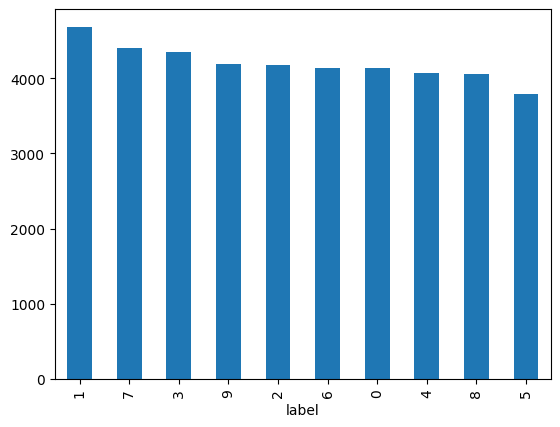

In [4]:
image_data['label'].value_counts().plot.bar()

In [5]:
X = image_data.loc[:,image_data.columns != 'label']
y = pd.get_dummies(image_data['label'])

In [6]:
def create_images(X):
    X = X.to_numpy().reshape(-1, 28, 28, 1)
    return X

In [7]:
class RandomAugment(keras.Model):
    def __init__(self, magnitude):
        super().__init__()

        self.layer = keras.Sequential([
            keras.layers.RandomRotation(0.5 * magnitude**2, fill_mode = 'constant'),
            keras.layers.RandomTranslation(magnitude**3, magnitude, fill_mode = 'constant'),
            keras.layers.RandomContrast(magnitude),
            keras.layers.GaussianNoise(magnitude)
        ])

    def call(self, x):
        return self.layer(x)
            

In [8]:
def show_images(X_image, magnitude = 0, nrows = 3, ncols = 3):
    plt.figure(figsize = (10,10))
    idx = np.random.choice(X_image.shape[0], nrows * ncols)

    images = X_image[idx]
    if magnitude > 0:
        images = RandomAugment(magnitude)(images, training = True)

    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(images[i], cmap = 'gray')
        plt.axis('off')

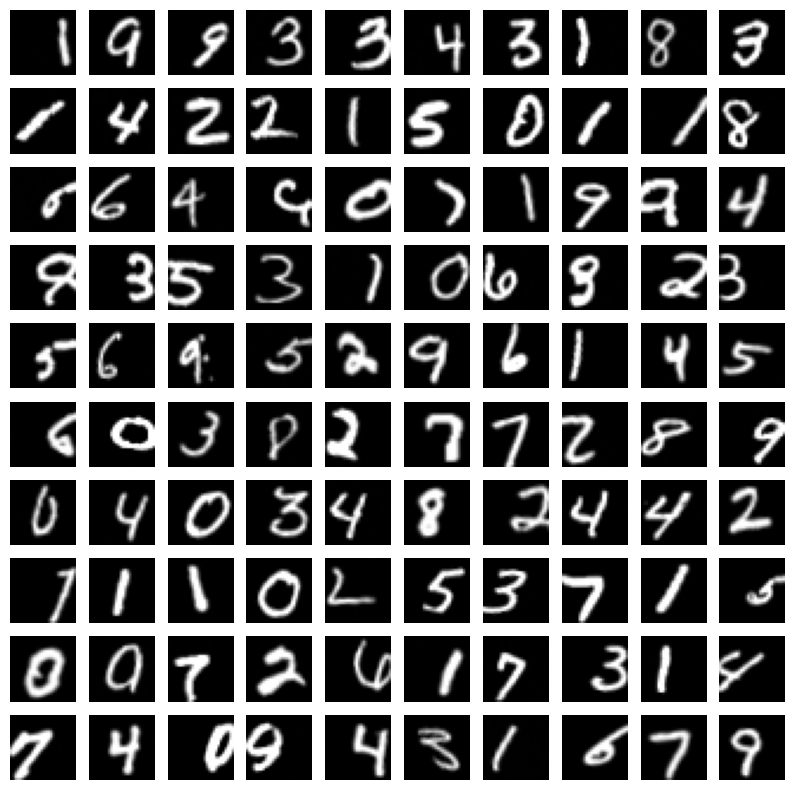

In [9]:
show_images(create_images(X), magnitude = 0.3, nrows = 10, ncols = 10)

In [10]:
def create_model():
    
    model = keras.Sequential([
        keras.layers.Input(shape = (28, 28, 1)),
        RandomAugment(magnitude = 0.15), # Different random augmentations every epoch, off during inference time
        keras.layers.Rescaling(1/255), # Rescale inputs from 0-255 to 0-1
        keras.layers.Conv2D(16, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same'),
        keras.layers.Conv2D(16, kernel_size = 3, activation = 'relu', padding = 'same'),
        keras.layers.Conv2D(32, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same'),
        keras.layers.Conv2D(256, kernel_size = 1, activation = 'relu'),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(10, activation = 'softmax')
    ])
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model


In [11]:
model = create_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_augment_1                │ (None, 28, 28, 1)      │             0 │
│ (RandomAugment)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 256)      │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,138 (70.85 KB)

 Trainable params: 18,138 (70.85 KB)

 Non-trainable params: 0 (0.00 B)

/Users/siddheshsongirkar/Startups/ai-recipe-gen/.venv312/lib/python3.12/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


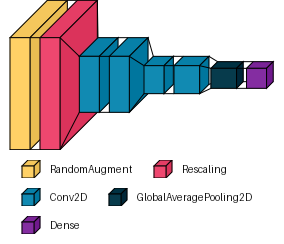

In [12]:
visualkeras.layered_view(model, legend = True)

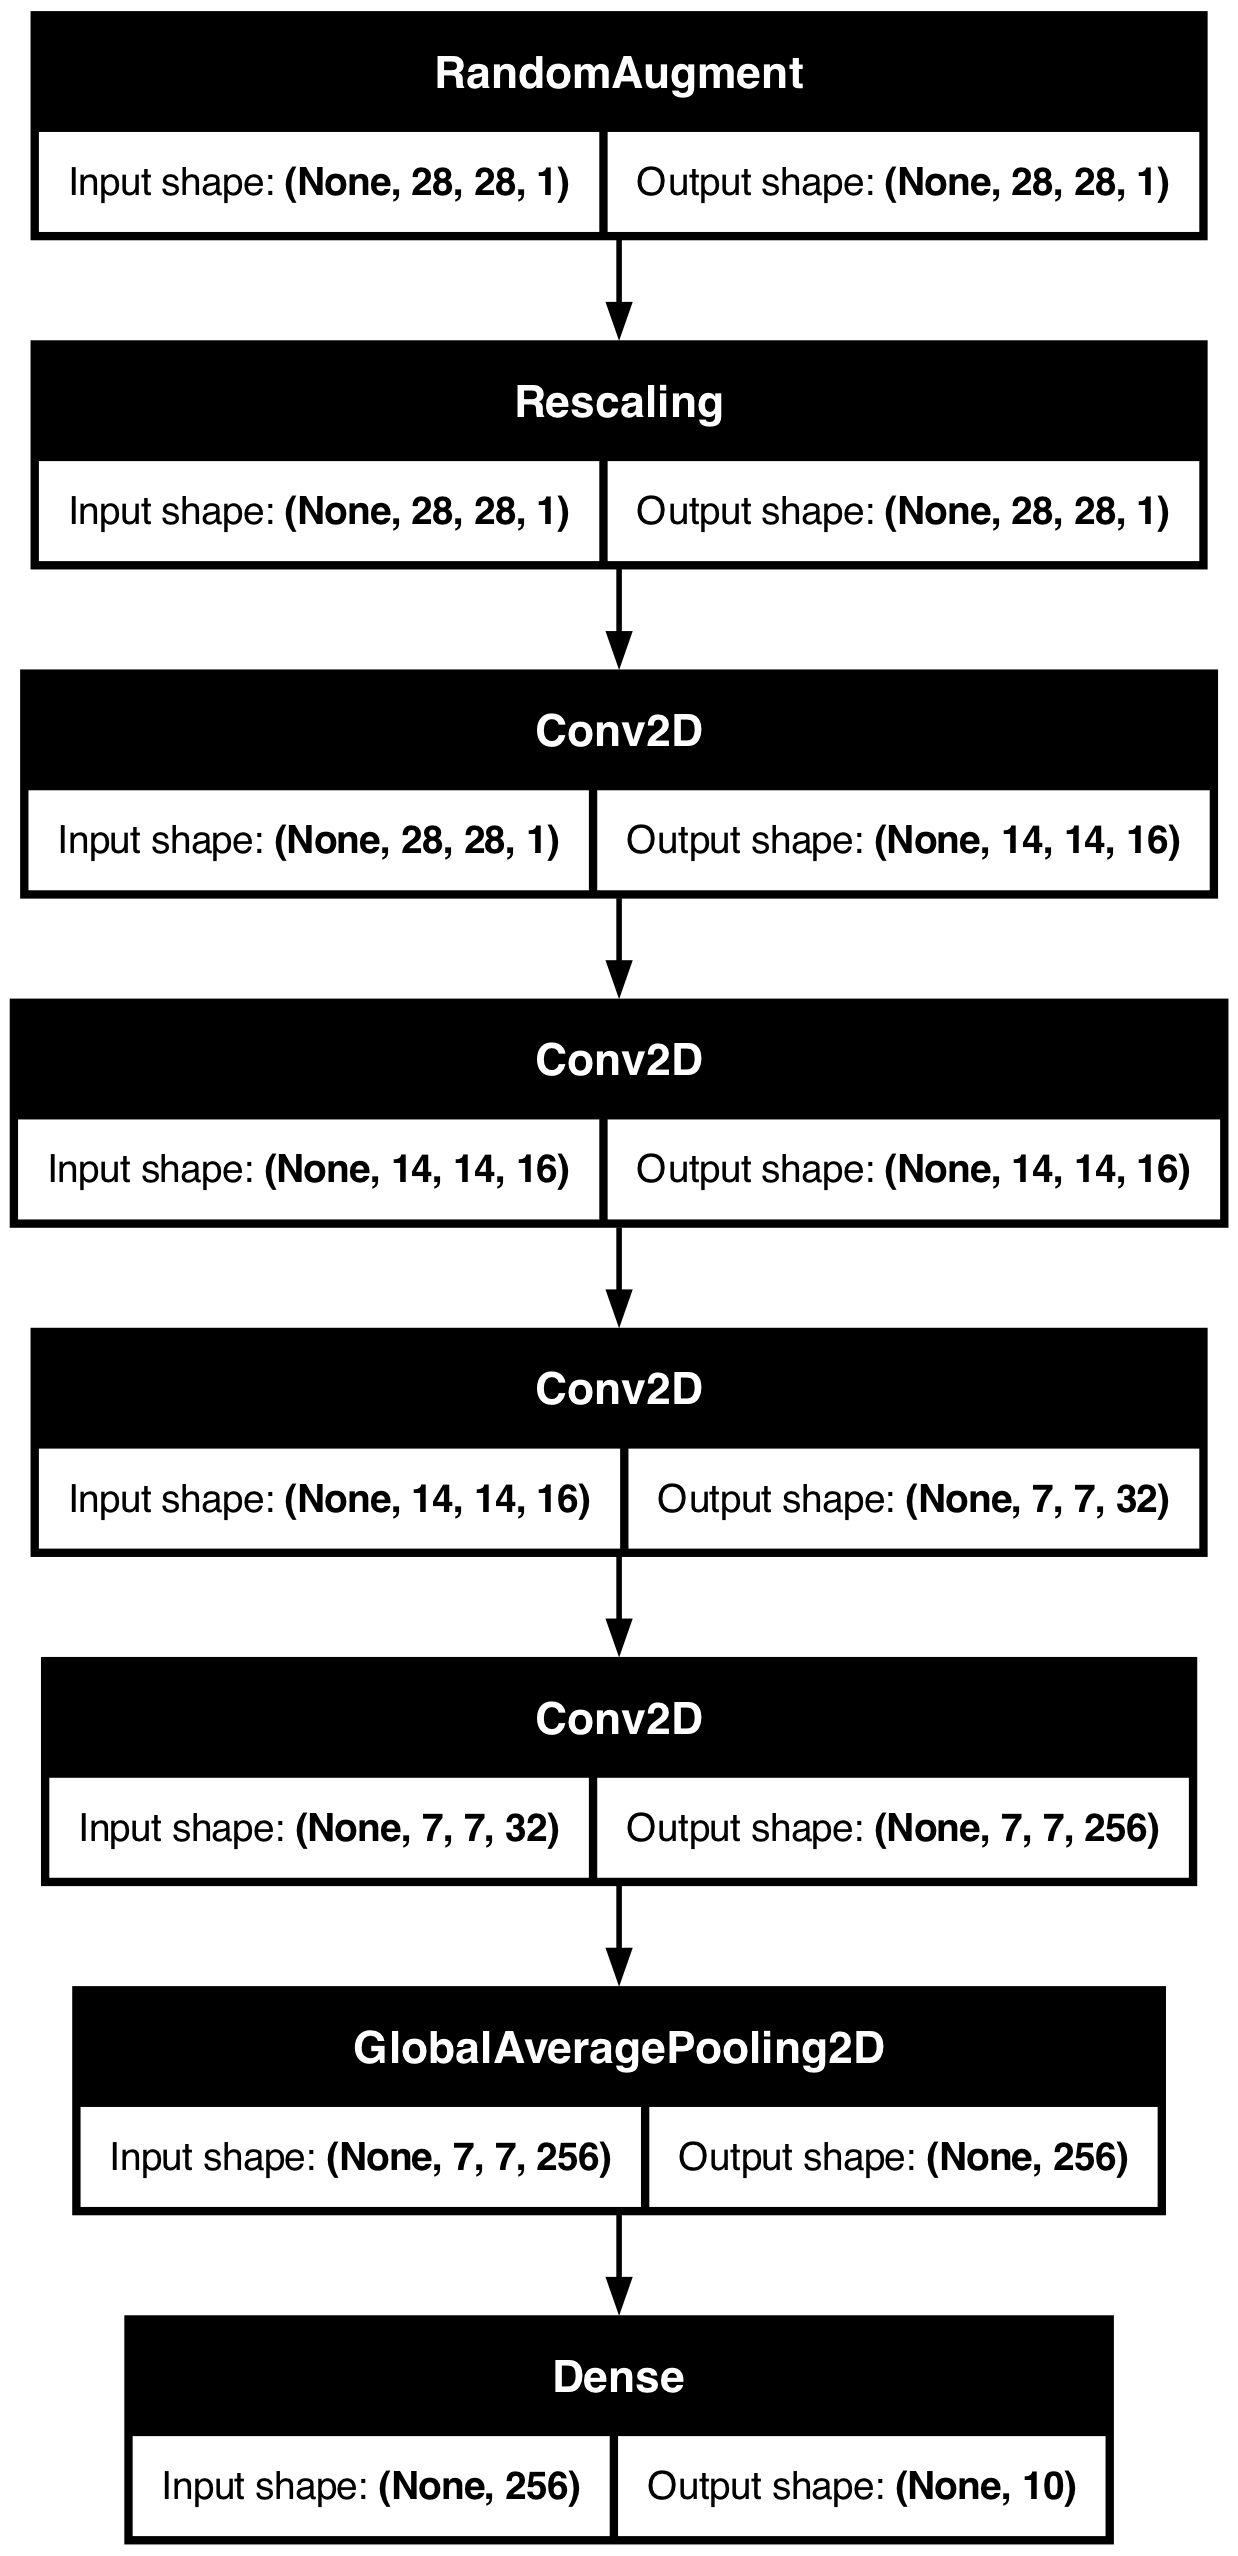

In [13]:
keras.utils.plot_model(model, show_shapes = True)

In [14]:
X_image = create_images(X)
X_train, X_val, y_train, y_val = train_test_split(X_image, y, test_size = 0.1)

In [15]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 20)

Epoch 1/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4119 - loss: 1.6287 - val_accuracy: 0.8340 - val_loss: 0.5370
Epoch 2/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8617 - loss: 0.4483 - val_accuracy: 0.8862 - val_loss: 0.3805
Epoch 3/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9040 - loss: 0.3104 - val_accuracy: 0.9267 - val_loss: 0.2431
Epoch 4/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9203 - loss: 0.2627 - val_accuracy: 0.9210 - val_loss: 0.2701
Epoch 5/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9324 - loss: 0.2318 - val_accuracy: 0.9371 - val_loss: 0.1997
Epoch 6/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9450 - loss: 0.1938 - val_accuracy: 0.9467 - val_loss: 0.1741
Epoch 7/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9477 - loss: 0.1730 - val_accuracy: 0.9550 - val_loss: 0.1575
Epoch 8/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9562 - loss: 0.1444 - 

<Axes: >

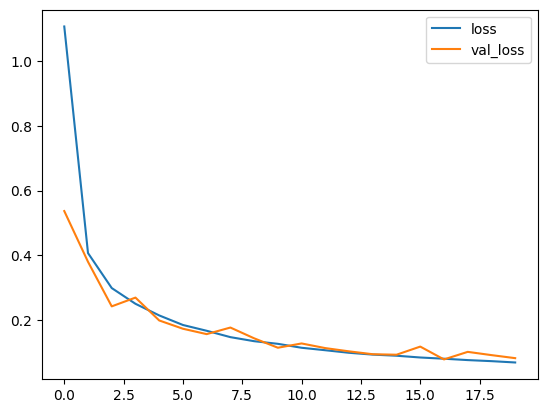

In [16]:
history_data = pd.DataFrame(history.history)
history_data[['loss', 'val_loss']].plot()

<Axes: >

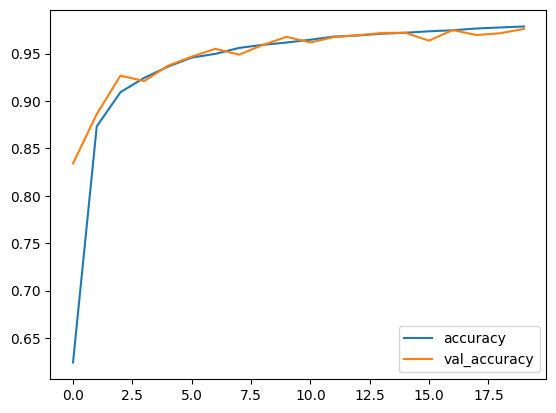

In [17]:
history_data[['accuracy', 'val_accuracy']].plot()

In [18]:
model.evaluate(X_val, y_val)

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9746 - loss: 0.0852


[0.08343537151813507, 0.9759523868560791]

In [15]:
class Conv(keras.Model):
    def __init__(self, filters, kernel_size = 3, strides = 1, activation = 'swish'):
        super().__init__()
        
        self.conv =  keras.Sequential([
            keras.layers.Conv2D(
                filters = filters, 
                kernel_size = kernel_size,
                strides = strides,
                padding = 'same',
                use_bias = False),
            keras.layers.BatchNormalization(),
            keras.layers.Activation(activation)
        ])
        
    def call(self, x):
        return self.conv(x)

In [21]:
def create_model(weight_decay = 3e-4):
    
    model = keras.Sequential([
        keras.layers.Input(shape = (28, 28,1)),
        RandomAugment(0.15),
        keras.layers.Rescaling(scale = 1/255),
        Conv(32, strides = 2),
        Conv(32),
        Conv(32),
        Conv(64, strides = 2),
        Conv(64),
        Conv(64),
        Conv(256, kernel_size = 1),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(10, activation = 'softmax')
    ])
    
    model.compile(
        loss = 'categorical_crossentropy', 
        optimizer = keras.optimizers.AdamW(weight_decay = weight_decay), 
        metrics = ['accuracy']
    )
    
    return model

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_augment_4                │ (None, 28, 28, 1)      │             0 │
│ (RandomAugment)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_14 (Conv)                  │ (None, 14, 14, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_15 (Conv)                  │ (None, 14, 14, 32)     │         9,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_16 (Conv)                  │ (None, 14, 14, 32)     │         9,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_17 (Conv)                  │ (None, 7, 7, 64)       │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_18 (Conv)                  │ (None, 7, 7, 64)       │        37,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_19 (Conv)                  │ (None, 7, 7, 64)       │        37,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_20 (Conv)                  │ (None, 7, 7, 256)      │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,010 (515.66 KB)

 Trainable params: 130,922 (511.41 KB)

 Non-trainable params: 1,088 (4.25 KB)

/Users/siddheshsongirkar/Startups/ai-recipe-gen/.venv312/lib/python3.12/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


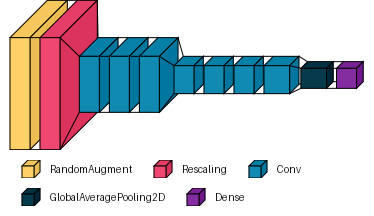

In [24]:
model = create_model()
model.summary()
visualkeras.layered_view(model, legend = True)

In [16]:

EPOCHS = 20
initial_lr = 5e-5
warmup_target = 3e-3
warmup_epochs = EPOCHS // 10
decay_epochs = EPOCHS - warmup_epochs

# CosineDecay instance for post-warmup phase
cosine_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=warmup_target,
    decay_steps=decay_epochs
)

# Custom scheduler that includes warmup
def lr_fn(epoch):
    if epoch < warmup_epochs:
        # Linear warmup from initial_lr to warmup_target
        return float(initial_lr + (warmup_target - initial_lr) * (epoch / warmup_epochs))
    else:
        # Cosine decay from warmup_target
        return float(cosine_schedule(epoch - warmup_epochs))

lr_schedule = keras.callbacks.LearningRateScheduler(lr_fn)

In [26]:
history = model.fit(X_train, y_train, 
          validation_data = (X_val, y_val), 
          epochs = 20, 
          callbacks = [lr_schedule])

Epoch 1/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.5423 - loss: 1.4583 - val_accuracy: 0.9417 - val_loss: 0.2563 - learning_rate: 5.0000e-05
Epoch 2/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - accuracy: 0.9506 - loss: 0.1719 - val_accuracy: 0.9795 - val_loss: 0.0703 - learning_rate: 0.0015
Epoch 3/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - accuracy: 0.9729 - loss: 0.0882 - val_accuracy: 0.9736 - val_loss: 0.0875 - learning_rate: 0.0030
Epoch 4/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 34s 29ms/step - accuracy: 0.9831 - loss: 0.0512 - val_accuracy: 0.9819 - val_loss: 0.0670 - learning_rate: 0.0030
Epoch 5/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - accuracy: 0.9856 - loss: 0.0461 - val_accuracy: 0.9821 - val_loss: 0.0626 - learning_rate: 0.0029
Epoch 6/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 34s 29ms/step - accuracy: 0.9863 - loss: 0.0440 - val_accuracy: 0.9781 - val_loss: 0.0667 - learning_rate: 0.0028
Epoch 7/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - ac

<Axes: >

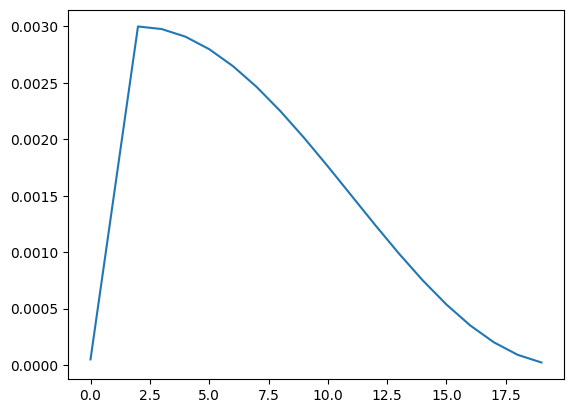

In [31]:
history_data = pd.DataFrame(history.history)
history_data['learning_rate'].plot()

<Axes: >

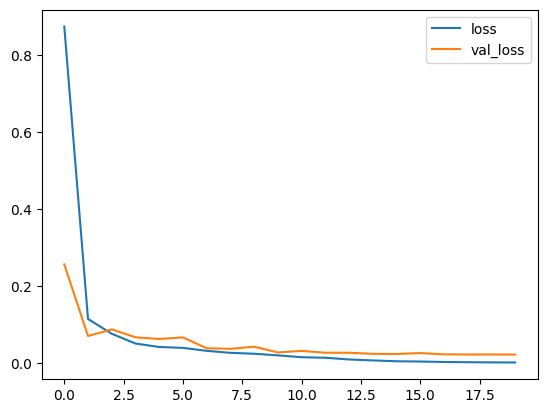

In [32]:
history_data[['loss', 'val_loss']].plot()

<Axes: >

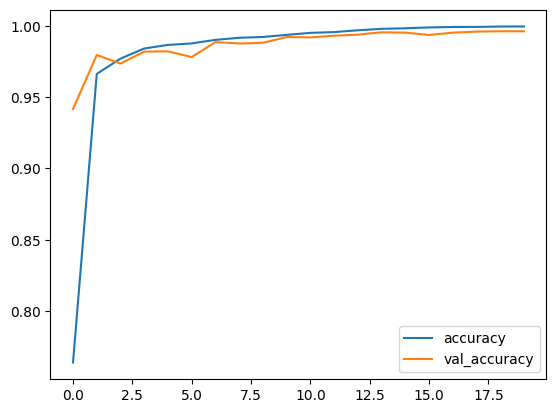

In [33]:
history_data[['accuracy', 'val_accuracy']].plot()

In [34]:
model.evaluate(X_val, y_val)

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9969 - loss: 0.0180


[0.022130591794848442, 0.9961904883384705]

In [17]:
class FusedMBConv(keras.Model):
    def __init__(self, filters, strides = 1, expansion_ratio = 4):
        super().__init__()
        self.skip = (strides == 1)
        
        self.expand = Conv(filters = expansion_ratio * filters, strides = strides)
        self.projection = Conv(filters, kernel_size = 1, activation = 'linear')
        
    def call(self, x):
        x_input = x
        
        x = self.expand(x)
        # EfficientNetV2 doesn't use SE in this block (despite whats depicted in the image)
        x = self.projection(x)
        
        if self.skip: x += x_input
            
        return x

In [18]:
class MBConv(keras.Model):
    def __init__(self, filters, strides = 1, expansion_ratio = 4, se_ratio = 0.25):
        super().__init__()
        self.skip = (strides == 1)
        
        self.expand = Conv(filters = expansion_ratio * filters, kernel_size = 1)
        
        self.depthwise = keras.layers.DepthwiseConv2D(
            kernel_size = 3, 
            strides = strides, 
            padding = 'same', 
            use_bias = False
        )
        self.bn = keras.layers.BatchNormalization()
        self.swish = keras.layers.Activation('swish')
        
        self.se = keras_cv.layers.SqueezeAndExcite2D(
            expansion_ratio * filters,
            bottleneck_filters = int(expansion_ratio * filters * se_ratio)
        )
        self.projection = Conv(filters, kernel_size = 1, activation = 'linear')
        
    def call(self, x):
        x_input = x
        
        x = self.expand(x)
        
        x = self.depthwise(x)
        x = self.bn(x)
        x = self.swish(x)
        
        x = self.se(x)
        
        x = self.projection(x)
        
        if self.skip: x += x_input
            
        return x

In [19]:
def create_model(weight_decay = 3e-4, magnitude = 0.15, res = 48, dropout = 0.1):
    
    model = keras.Sequential([
        keras.layers.Input(shape = (28, 28, 1)),
        keras.layers.Resizing(res, res),
        RandomAugment(magnitude),
        keras.layers.Rescaling(1/255),
        Conv(filters = 16, strides = 2),
        FusedMBConv(16, expansion_ratio = 1),
        FusedMBConv(16),
        FusedMBConv(16),
        MBConv(filters = 32, strides = 2),
        MBConv(32),
        MBConv(32),
        MBConv(64, strides = 2),
        MBConv(filters = 64, expansion_ratio = 6),
        MBConv(filters = 64, expansion_ratio = 6),
        Conv(filters = 256, kernel_size = 1),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dropout(dropout), # Add dropout regularization
        keras.layers.Dense(10, activation = 'softmax')
    ])
    
    model.compile(
        loss = keras.losses.CategoricalCrossentropy(label_smoothing = 0.05), # Include label smoothing
        optimizer = keras.optimizers.AdamW(weight_decay = weight_decay), 
        metrics = ['accuracy']
    )
    
    return model

In [20]:
model = create_model()
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_augment_2                │ (None, 48, 48, 1)      │             0 │
│ (RandomAugment)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv (Conv)                     │ (None, 24, 24, 16)     │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fused_mb_conv (FusedMBConv)     │ (None, 24, 24, 16)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fused_mb_conv_1 (FusedMBConv)   │ (None, 24, 24, 16)     │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fused_mb_conv_2 (FusedMBConv)   │ (None, 24, 24, 16)     │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mb_conv (MBConv)                │ (None, 12, 12, 32)     │        16,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mb_conv_1 (MBConv)              │ (None, 12, 12, 32)     │        18,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mb_conv_2 (MBConv)              │ (None, 12, 12, 32)     │        18,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mb_conv_3 (MBConv)              │ (None, 6, 6, 64)       │        62,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mb_conv_4 (MBConv)              │ (None, 6, 6, 64)       │       130,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mb_conv_5 (MBConv)              │ (None, 6, 6, 64)       │       130,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_19 (Conv)                  │ (None, 6, 6, 256)      │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,050 (1.61 MB)

 Trainable params: 413,914 (1.58 MB)

 Non-trainable params: 7,136 (27.88 KB)

/Users/siddheshsongirkar/Startups/ai-recipe-gen/.venv312/lib/python3.12/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


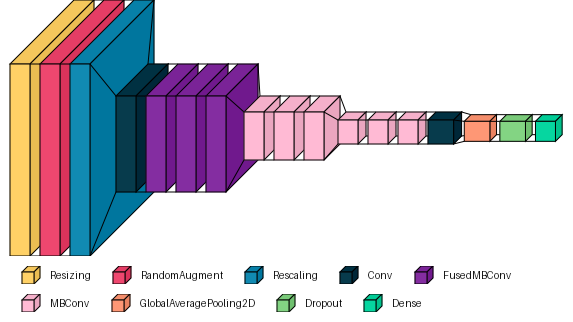

In [21]:
visualkeras.layered_view(model, legend = True)

In [22]:
class LinearSchedule:
    def __init__(self, initial, final, stages):
        self.initial = initial
        self.final = final
        self.timesteps = stages - 1
        
    def __call__(self, t):
        return self.initial * (1 - t / self.timesteps) + self.final * (t / self.timesteps)

def progressive_learning(X_train, X_val, y_train, y_val, 
                epochs_per_stage, 
                create_model = create_model,
                stages = 3,
                initial_res = 28, final_res = 48,
                initial_dropout = 0.1, final_dropout = 0.3,
                initial_magnitude = 0.1, final_magnitude = 0.3,
                model_path = 'models/number.weights.h5'):
    
    dropout_schedule = LinearSchedule(initial_dropout, final_dropout, stages)
    res_schedule = LinearSchedule(initial_res, final_res, stages)
    magnitude_schedule = LinearSchedule(initial_magnitude, final_magnitude, stages)
    
    history = []
    
    for t in range(stages):
        dropout = dropout_schedule(t)
        res = int(res_schedule(t))
        magnitude = magnitude_schedule(t)
        print(f'{t + 1} / {stages} | dropout: {dropout}, res: {res}, magnitude: {magnitude}, path: {model_path}')
                
        model = create_model(res = res, dropout = dropout, magnitude = magnitude)
        
        lr_schedule = keras.callbacks.LearningRateScheduler(
            lambda epoch: float( keras.optimizers.schedules.CosineDecay(
                initial_learning_rate = 1e-4,
                decay_steps = stages * epochs_per_stage - 1,
                warmup_target = 3e-3,
                warmup_steps = 1
            )(t * epochs_per_stage + epoch)
            )
        )
        
        if t != 0:
            model.load_weights(model_path)
        
        stage_history = model.fit(X_train, y_train, 
                  batch_size = 32, epochs = epochs_per_stage,
                  validation_data = (X_val, y_val),
                  callbacks = [lr_schedule])
        history.append(pd.DataFrame(stage_history.history))
        
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        model.save_weights(model_path)
        
    history_data = pd.concat(history).reset_index()
        
    return model, history_data

In [23]:
model, history_data = progressive_learning(
    X_train, X_val, y_train, y_val,
    epochs_per_stage = 10, stages = 3
)

1 / 3 | dropout: 0.1, res: 28, magnitude: 0.1, path: models/number.weights.h5
Epoch 1/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 102s 80ms/step - accuracy: 0.6619 - loss: 1.2210 - val_accuracy: 0.9726 - val_loss: 0.3948 - learning_rate: 1.0000e-04
Epoch 2/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 98s 83ms/step - accuracy: 0.9473 - loss: 0.4585 - val_accuracy: 0.9745 - val_loss: 0.3640 - learning_rate: 0.0030
Epoch 3/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 108s 91ms/step - accuracy: 0.9787 - loss: 0.3545 - val_accuracy: 0.9812 - val_loss: 0.3465 - learning_rate: 0.0030
Epoch 4/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 102s 87ms/step - accuracy: 0.9835 - loss: 0.3399 - val_accuracy: 0.9707 - val_loss: 0.3803 - learning_rate: 0.0030
Epoch 5/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 96s 82ms/step - accuracy: 0.9854 - loss: 0.3327 - val_accuracy: 0.9788 - val_loss: 0.3609 - learning_rate: 0.0029
Epoch 6/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 102s 86ms/step - accuracy: 0.9890 - loss: 0.3230 - val_accuracy: 0.9883 - val_loss: 0.3219 - 

/Users/siddheshsongirkar/Startups/ai-recipe-gen/.venv312/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 210 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 148s 119ms/step - accuracy: 0.9849 - loss: 0.3332 - val_accuracy: 0.9867 - val_loss: 0.3218 - learning_rate: 0.0023
Epoch 2/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 124s 105ms/step - accuracy: 0.9912 - loss: 0.3160 - val_accuracy: 0.9905 - val_loss: 0.3089 - learning_rate: 0.0022
Epoch 3/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 141s 119ms/step - accuracy: 0.9929 - loss: 0.3083 - val_accuracy: 0.9874 - val_loss: 0.3189 - learning_rate: 0.0021
Epoch 4/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 143s 121ms/step - accuracy: 0.9931 - loss: 0.3075 - val_accuracy: 0.9924 - val_loss: 0.3082 - learning_rate: 0.0019
Epoch 5/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 151s 128ms/step - accuracy: 0.9945 - loss: 0.3030 - val_accuracy: 0.9929 - val_loss: 0.3030 - learning_rate: 0.0017
Epoch 6/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 159s 135ms/step - accuracy: 0.9957 - loss: 0.3009 - val_accuracy: 0.9931 - val_loss: 0.3022 - learning_rate: 0.0016
Epoch 7/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 154s 130ms

/Users/siddheshsongirkar/Startups/ai-recipe-gen/.venv312/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 210 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 241s 196ms/step - accuracy: 0.9873 - loss: 0.3233 - val_accuracy: 0.9943 - val_loss: 0.2984 - learning_rate: 7.9739e-04
Epoch 2/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 187s 158ms/step - accuracy: 0.9935 - loss: 0.3060 - val_accuracy: 0.9938 - val_loss: 0.2989 - learning_rate: 6.5822e-04
Epoch 3/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 182s 154ms/step - accuracy: 0.9947 - loss: 0.3027 - val_accuracy: 0.9960 - val_loss: 0.2985 - learning_rate: 5.2892e-04
Epoch 4/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 190s 161ms/step - accuracy: 0.9957 - loss: 0.3011 - val_accuracy: 0.9969 - val_loss: 0.2932 - learning_rate: 4.1101e-04
Epoch 5/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 171s 144ms/step - accuracy: 0.9959 - loss: 0.2989 - val_accuracy: 0.9955 - val_loss: 0.2955 - learning_rate: 3.0586e-04
Epoch 6/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 226s 192ms/step - accuracy: 0.9967 - loss: 0.2971 - val_accuracy: 0.9955 - val_loss: 0.2946 - learning_rate: 2.1471e-04
Epoch 7/10
1182/1182 ━━━━━━━

<Axes: >

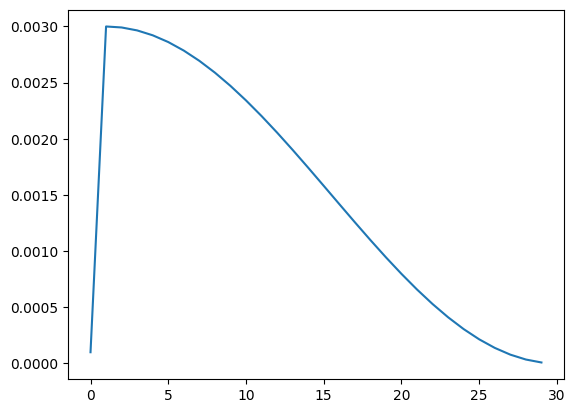

In [25]:
history_data['learning_rate'].plot()

<Axes: >

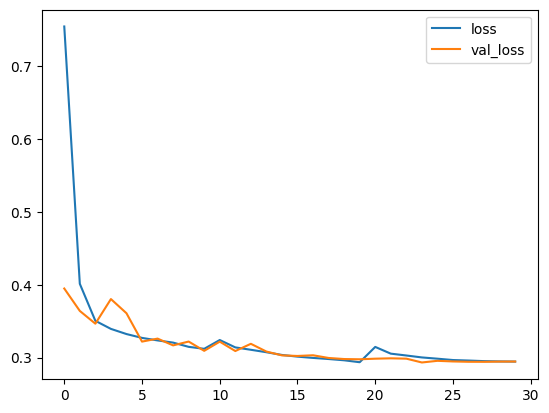

In [26]:
history_data[['loss', 'val_loss']].plot()

<Axes: >

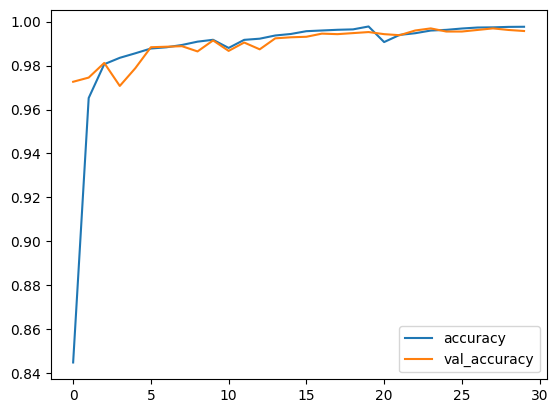

In [27]:
history_data[['accuracy', 'val_accuracy']].plot()

In [28]:
modelo = create_model()

In [30]:
modelo.load_weights('models/number.weights.h5')
modelo.evaluate(X_val, y_val)

132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9961 - loss: 0.2945


[0.2945243716239929, 0.9957143068313599]